In [403]:
import pandas as pd
from collections import Counter

df_train = pd.read_csv('data/train.csv') # 训练集
df_train['way'] = 'train'
# df_train.drop(['id'], axis=1, inplace=True)
df_vaild = pd.read_csv('data/tmp.csv')
df_vaild.drop(['Unnamed: 0', 'way'], axis=1, inplace=True)
df_vaild['way'] = 'vaild'
df_train = pd.concat([df_train,df_vaild])


In [404]:
df_train = df_train.reset_index(drop=True)
# df_train = df_train.drop(['index'], axis=1,inplace=True)

In [405]:
# 数据格式处理
num_feat = ['Age', 'Vintage', 'Annual_Premium'] # 数值属性
nor_feat = ['Gender', 'Driving_License', 'Region_Code', 'Vehicle_Damage',  'Vehicle_Age', 'Policy_Sales_Channel', 'Previously_Insured'] # 标称属性

# df_train.drop(['Unnamed: 0', 'way'], axis=1, inplace=True)

In [406]:
# 缺失值检测处理：轮盘法按概率填充（标称属性）
import random

null_pro = ['Driving_License', 'Policy_Sales_Channel']
for pro in null_pro:
    countPro = Counter([x for x in df_train[pro] if pd.isnull(x) == False])
    print(countPro)
    sumPro = sum(countPro.values())
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            needle = random.random() 
            needle *= sumPro
            for cur in countPro.most_common():
                needle -= cur[1]
                if needle <= 0:
                    df_train[pro][index] = cur[0]
                    break
df_train.info()

Counter({1.0: 379419, 0.0: 812})
/home/haojie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
Counter({152.0: 134454, 26.0: 79523, 124.0: 73829, 160.0: 21714, 156.0: 10640, 122.0: 9920, 157.0: 6679, 154.0: 5978, 151.0: 3877, 163.0: 2883, 13.0: 1856, 25.0: 1840, 7.0: 1598, 8.0: 1511, 30.0: 1408, 55.0: 1262, 155.0: 1230, 11.0: 1198, 1.0: 1072, 52.0: 1053, 125.0: 1023, 15.0: 889, 29.0: 842, 12.0: 779, 120.0: 768, 24.0: 749, 31.0: 629, 14.0: 618, 153.0: 607, 61.0: 579, 3.0: 524, 16.0: 522, 60.0: 516, 4.0: 507, 158.0: 491, 23.0: 420, 22.0: 331, 150.0: 310, 10.0: 264, 19.0: 221, 147.0: 182, 136.0: 182, 109.0: 174, 145.0: 173, 9.0: 168, 18.0: 167, 91.0: 158, 116.0: 154, 37.0: 154, 21.0: 148, 139.0: 143, 128.0: 136, 42.0: 1

In [407]:
def Feature_Aggregations(df_train): # 特征聚合
    df_Merge = df_train.copy()

    # 销售渠道相关
    df_Merge['Policy_Region'] = df_Merge['Policy_Sales_Channel'].astype(str)+'_'+df_Merge['Region_Code'].astype(str)

    # 汽车相关
    # df_Merge['Vehicle_Age_Damage_License'] = df_Merge['Vehicle_Age'].astype(str)+'_'+df_Merge['Vehicle_Damage'].astype(str)+'_'+df_Merge['Driving_License'].astype(str)

    mix_feat = ['Policy_Region']
    num_feat = ['Age', 'Annual_Premium', 'Vintage']
    for mix in mix_feat:
        for num in num_feat:
            df_TMP_Merge = df_Merge.groupby(mix)[num].agg(['mean', 'std','nunique']).fillna(0)
            df_TMP_Merge.columns = ['mean_' + mix + '_' + num, 'std_' + mix + '_' + num, 'nunique_' + mix + '_' + num]
            df_Merge = df_Merge.merge(df_TMP_Merge, left_on = mix ,right_index=True, how = 'left')
            
    ### Policy_Region 和  Vehicle_Age_Damage_License 的目的只是用来做特征聚类，做完后删除这两列
    return df_Merge.drop(mix_feat, axis=1)


In [408]:
df_train_agg = Feature_Aggregations(df_train)
df_train_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    381109 non-null  int64  
 1   Gender                                381109 non-null  object 
 2   Age                                   381109 non-null  int64  
 3   Driving_License                       381109 non-null  float64
 4   Region_Code                           381109 non-null  float64
 5   Previously_Insured                    381109 non-null  int64  
 6   Vehicle_Age                           381109 non-null  object 
 7   Vehicle_Damage                        381109 non-null  object 
 8   Annual_Premium                        381109 non-null  float64
 9   Policy_Sales_Channel                  381109 non-null  float64
 10  Vintage                               381109 non-null  int64  
 11  

In [409]:
# 提取Policy_Sales_Channel中频率大的样本，进行编码
import numpy as np
psc_min = np.int(np.min(df_train_agg['Policy_Sales_Channel']))
psc_max = np.int(np.max(df_train_agg['Policy_Sales_Channel']))
psc_counts = [ np.sum(df_train_agg['Policy_Sales_Channel'] == i) for i in range(psc_min, psc_max+1)]
psc_sort = psc_counts.copy()
psc_sort.sort(reverse=True)
psc_threshold = psc_sort[2]



In [410]:
psc_cats = 3
df_train_agg['Policy_Sales_Channel'] = df_train_agg['Policy_Sales_Channel'].astype('int')
train_psc = df_train_agg['Policy_Sales_Channel'].copy()
for i in range(len(train_psc)):
    now_psc = train_psc[i]-1
    if (psc_counts[now_psc] >= psc_threshold):
        for j in range(psc_cats):
            if (psc_sort[j] == psc_counts[now_psc]):
                train_psc[i] = j+1
                break
    else:
        train_psc[i] = 0

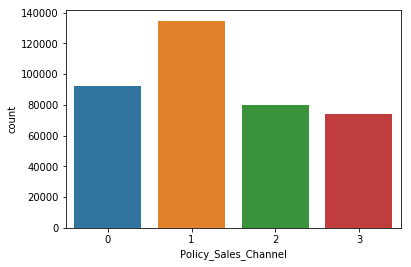

In [411]:
import seaborn as sns
sns.countplot(train_psc)

In [412]:
df_train_agg['PSC_Plus'] = train_psc
df_train_agg['PSC_Plus'] = df_train_agg['PSC_Plus'].astype('str')
# df_train_agg=pd.get_dummies(df_train_agg ,drop_first=True)

In [413]:
df_train_agg

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,mean_Policy_Region_Age,std_Policy_Region_Age,nunique_Policy_Region_Age,mean_Policy_Region_Annual_Premium,std_Policy_Region_Annual_Premium,nunique_Policy_Region_Annual_Premium,mean_Policy_Region_Vintage,std_Policy_Region_Vintage,nunique_Policy_Region_Vintage,PSC_Plus
0,0,Male,27,1.0,46.0,1,< 1 Year,No,33138.0,152,...,25.368349,5.782044,52,28692.804348,10776.206599,5269,153.742019,84.324167,290,1
1,1,Female,44,1.0,28.0,0,> 2 Years,Yes,60529.0,26,...,51.447656,12.006194,66,40305.919541,17732.672073,21534,154.276105,83.739435,290,2
2,2,Male,52,1.0,46.0,0,> 2 Years,Yes,22476.0,124,...,46.490884,11.923756,62,27639.782313,12297.386051,2853,153.779592,83.784946,290,3
3,3,Male,23,1.0,46.0,1,< 1 Year,No,2630.0,152,...,25.368349,5.782044,52,28692.804348,10776.206599,5269,153.742019,84.324167,290,1
4,4,Female,43,1.0,28.0,0,1-2 Year,Yes,32543.0,124,...,46.972322,12.202753,65,38575.319676,17342.920486,17036,154.698849,83.438898,290,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,76216,Female,46,1.0,3.0,0,> 2 Years,Yes,30714.0,26,...,50.539577,13.409988,60,25793.568580,15840.237805,1209,154.548036,82.403943,289,2
381105,76217,Female,37,1.0,0.0,0,1-2 Year,No,2630.0,61,...,46.928571,10.523091,21,2630.000000,0.000000,1,196.392857,80.288526,24,0
381106,76218,Male,33,1.0,49.0,1,< 1 Year,No,33553.0,152,...,26.067141,5.997757,38,24754.181078,11965.374232,750,154.773143,80.756406,281,1
381107,76219,Male,72,1.0,28.0,0,> 2 Years,Yes,34283.0,124,...,46.972322,12.202753,65,38575.319676,17342.920486,17036,154.698849,83.438898,290,3


In [414]:
# 提取Region_Code中出现频率最大的样本，进行编码
df_train_agg['Region_Code'] = df_train_agg['Region_Code'].astype('int')
rc_min = np.int(np.min(df_train_agg['Region_Code']))
rc_max = np.int(np.max(df_train_agg['Region_Code']))
rc_counts = [ np.sum(df_train_agg['Region_Code'] == i) for i in range(rc_min, rc_max+1)]
rc_sort = rc_counts.copy()
rc_sort.sort(reverse=True)
rc_threshold = rc_sort[0]
rc_cats = 1

train_rc = df_train_agg['Region_Code'].copy()
for i in range(len(train_rc)):
    now_rc = train_rc[i]-rc_min
    if (rc_counts[now_rc] >= rc_threshold):
        for j in range(rc_cats):
            if (rc_sort[j] == rc_counts[now_rc]):
                train_rc[i] = j+1
                break
    else:
        train_rc[i] = 0
train_rc

0         0
1         1
2         0
3         0
4         1
         ..
381104    0
381105    0
381106    0
381107    1
381108    0
Name: Region_Code, Length: 381109, dtype: int64

In [415]:
df_train_agg['RC_Plus'] = train_rc
df_train_agg['RC_Plus'] = df_train_agg['RC_Plus'].astype('str')

real_train = df_train_agg[df_train_agg['way'] == 'train']
real_vaild = df_train_agg[df_train_agg['way'] == 'vaild']

real_train = real_train.drop(['way'],axis=1)
real_vaild = real_vaild.drop(['way'],axis=1)


In [416]:
real_train=pd.get_dummies(real_train,drop_first=True)
real_train=real_train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_1_Year_down", "Vehicle_Age_> 2 Years": "Vehicle_Age_2_Years_up"})

real_train

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,mean_Policy_Region_Age,...,std_Policy_Region_Vintage,nunique_Policy_Region_Vintage,Gender_Male,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3,RC_Plus_1
0,0,27,1.0,46,1,33138.0,152,223,0,25.368349,...,84.324167,290,1,1,0,0,1,0,0,0
1,1,44,1.0,28,0,60529.0,26,158,1,51.447656,...,83.739435,290,0,0,1,1,0,1,0,1
2,2,52,1.0,46,0,22476.0,124,226,1,46.490884,...,83.784946,290,1,0,1,1,0,0,1,0
3,3,23,1.0,46,1,2630.0,152,163,0,25.368349,...,84.324167,290,1,1,0,0,1,0,0,0
4,4,43,1.0,28,0,32543.0,124,56,1,46.972322,...,83.438898,290,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304883,304883,20,1.0,7,0,2630.0,160,264,0,24.259124,...,83.613991,173,0,1,0,1,0,0,0,0
304884,304884,24,1.0,20,0,2630.0,26,63,0,52.592058,...,83.476452,245,0,1,0,1,0,1,0,0
304885,304885,25,1.0,36,1,26826.0,152,26,0,25.735354,...,84.359467,290,0,1,0,0,1,0,0,0
304886,304886,22,1.0,8,1,71548.0,152,140,0,25.964049,...,83.797696,290,1,1,0,0,1,0,0,0


In [417]:
real_vaild=pd.get_dummies(real_vaild,drop_first=True)
real_vaild=real_vaild.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_1_Year_down", "Vehicle_Age_> 2 Years": "Vehicle_Age_2_Years_up"})
real_vaild

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,mean_Policy_Region_Age,...,std_Policy_Region_Vintage,nunique_Policy_Region_Vintage,Gender_Male,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3,RC_Plus_1
304888,0,41,1.0,6,0,36438.0,124,119,0,45.676951,...,80.944768,250,1,0,0,1,0,0,1,0
304889,1,28,1.0,28,1,44632.0,152,91,0,27.218766,...,83.716335,290,0,1,0,0,1,0,0,1
304890,2,32,1.0,8,0,36838.0,124,83,0,47.871618,...,84.575106,290,0,0,0,1,0,0,1,0
304891,3,36,1.0,28,1,30074.0,122,273,0,52.461135,...,83.387038,290,1,0,0,0,0,0,0,1
304892,4,32,1.0,15,0,38230.0,152,297,0,26.666575,...,83.465197,290,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,76216,46,1.0,3,0,30714.0,26,148,0,50.539577,...,82.403943,289,0,0,1,1,0,1,0,0
381105,76217,37,1.0,0,0,2630.0,61,143,0,46.928571,...,80.288526,24,0,0,0,0,0,0,0,0
381106,76218,33,1.0,49,1,33553.0,152,267,0,26.067141,...,80.756406,281,1,1,0,0,1,0,0,0
381107,76219,72,1.0,28,0,34283.0,124,284,0,46.972322,...,83.438898,290,1,0,1,1,0,0,1,1


In [418]:
def normalize(data):
    z_feat = ['Annual_Premium', 'Age']
    for attr in data.columns:
        min_v = np.min(data[attr])
        max_v = np.max(data[attr])
        if (min_v == 0 and max_v == 1):
            continue
        mean_v = np.mean(data[attr])
        std_v = np.std(data[attr])
        if (std_v == 0):
            continue
        # if attr in z_feat:
        data[attr] = (data[attr] - mean_v) / std_v
        # else:
            # data[attr] = (data[attr] - min_v) / (max_v - min_v)

normalize(real_train)
normalize(real_vaild)

In [419]:
## 特征聚类结果导出
real_train.to_csv('data/train_clean_v4.csv', index=False)
real_vaild.to_csv('data/tmp_clean_v4.csv', index=False)
# df_train_agg.to_csv('data/tmp_clean_v4.csv', index=False)

In [420]:
train = pd.read_csv('data/tmp_clean_v4.csv')


In [421]:
train

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,mean_Policy_Region_Age,...,std_Policy_Region_Vintage,nunique_Policy_Region_Vintage,Gender_Male,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3,RC_Plus_1
0,0.000000,0.143477,1.0,0.115385,0,0.336961,0.759259,0.377163,0,0.442706,...,0.493419,0.861592,1,0,0,1,0,0,1,0
1,0.000013,-0.695237,1.0,0.538462,1,0.811089,0.932099,0.280277,0,0.124461,...,0.510314,1.000000,0,1,0,0,1,0,0,1
2,0.000026,-0.437171,1.0,0.153846,0,0.360106,0.759259,0.252595,0,0.480545,...,0.515549,1.000000,0,0,0,1,0,0,1,0
3,0.000039,-0.179105,1.0,0.538462,1,-0.031278,0.746914,0.910035,0,0.559675,...,0.508306,1.000000,1,0,0,0,0,0,0,1
4,0.000052,-0.437171,1.0,0.288462,0,0.440651,0.932099,0.993080,0,0.114941,...,0.508783,1.000000,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,0.999948,0.466060,1.0,0.057692,0,0.005754,0.154321,0.477509,0,0.526544,...,0.502314,0.996540,0,0,1,1,0,1,0,0
76217,0.999961,-0.114588,1.0,0.000000,0,-1.619267,0.370370,0.460208,0,0.464286,...,0.489419,0.079585,0,0,0,0,0,0,0,0
76218,0.999974,-0.372654,1.0,0.942308,1,0.170026,0.932099,0.889273,0,0.104606,...,0.492271,0.968858,1,1,0,0,1,0,0,0
76219,0.999987,2.143487,1.0,0.538462,0,0.212266,0.759259,0.948097,0,0.465040,...,0.508623,1.000000,1,0,1,1,0,0,1,1
